In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding, multiply, Concatenate, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Combine train and test images and labels
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Normalize images to [-1, 1]
all_images = (all_images.astype(np.float32) - 127.5) / 127.5
all_images = np.expand_dims(all_images, axis=-1)

# Select a subset of 8,000 images and labels
subset_indices = np.random.choice(all_images.shape[0], 8000, replace=False)
subset_images = all_images[subset_indices]
subset_labels = all_labels[subset_indices]

# Parameters
img_shape = (28, 28, 1)
num_classes = 10
latent_dim = 100

# Build the Generator
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

# Build the Discriminator
def build_discriminator():
    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])
    validity = model(model_input)

    return Model([img, label], validity)

# Compile the models
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()

noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

discriminator.trainable = False

valid = discriminator([img, label])

combined = Model([noise, label], valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# Function to generate and display images
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Class: {sampled_labels[cnt]}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Training the Conditional GAN
def train(epochs, batch_size=128, sample_interval=200):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, subset_images.shape[0], batch_size)
        imgs, labels = subset_images[idx], subset_labels[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        gen_imgs = generator.predict([noise, gen_labels])

        d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        g_loss = combined.train_on_batch([noise, sampled_labels], valid)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")
            sample_images(epoch)

# Train the cGAN for 10000 epochs
train(epochs=10000, batch_size=64, sample_interval=1000)

# Real vs Fake analysis
def real_vs_fake():
    noise = np.random.normal(0, 1, (10, latent_dim))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = generator.predict([noise, sampled_labels])
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axs[0, i].imshow(subset_images[i, :, :, 0], cmap='gray')
        axs[0, i].set_title(f"Real: {subset_labels[i]}")
        axs[0, i].axis('off')
        axs[1, i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
        axs[1, i].set_title(f"Fake: {i}")
        axs[1, i].axis('off')
    plt.show()

real_vs_fake()

2/2 [==============================] - 0s 11ms/step


KeyError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable embedding_5/embeddings:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


2/2 [==============================] - 0s 9ms/step


0 [D loss: 0.6934620440006256, acc.: 35.9375%] [G loss: 0.6771427392959595]
1/1 [==============================] - 0s 149ms/step


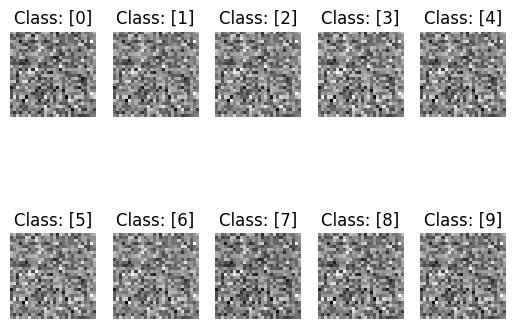

2/2 [==============================] - 0s 12ms/step
1000 [D loss: 0.6370347738265991, acc.: 60.9375%] [G loss: 0.8140013217926025]
2/2 [==============================] - 0s 12ms/step
2000 [D loss: 0.6955054998397827, acc.: 48.4375%] [G loss: 0.719967782497406]
1/1 [==============================] - 0s 30ms/step


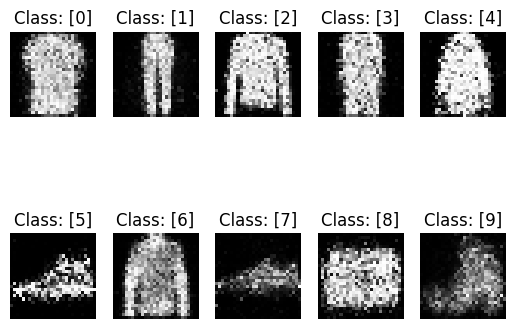

2/2 [==============================] - 0s 13ms/step
3000 [D loss: 0.6910879015922546, acc.: 53.90625%] [G loss: 0.7266208529472351]
1/1 [==============================] - 0s 29ms/step


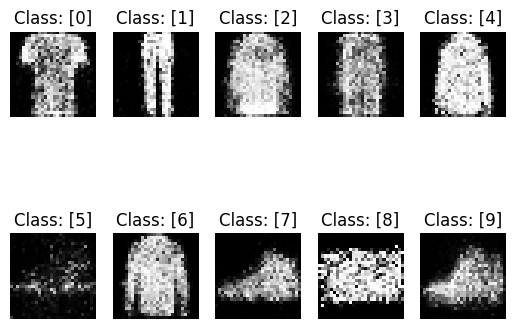

2/2 [==============================] - 0s 12ms/step
4000 [D loss: 0.6963009834289551, acc.: 50.78125%] [G loss: 0.7251697182655334]
1/1 [==============================] - 0s 33ms/step


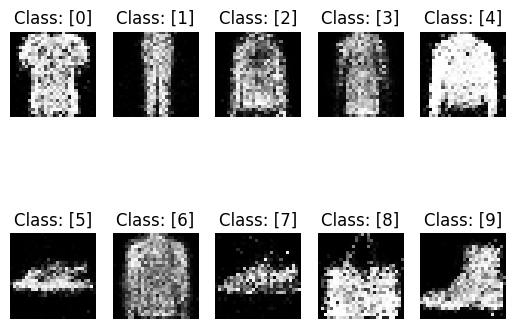

2/2 [==============================] - 0s 14ms/step
5000 [D loss: 0.687329888343811, acc.: 53.125%] [G loss: 0.7078542709350586]
1/1 [==============================] - 0s 34ms/step


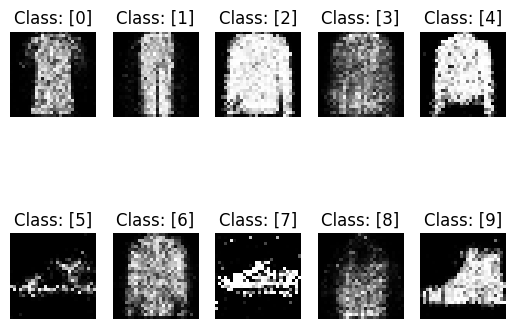

2/2 [==============================] - 0s 11ms/step
6000 [D loss: 0.6894052028656006, acc.: 49.21875%] [G loss: 0.7412705421447754]
1/1 [==============================] - 0s 24ms/step


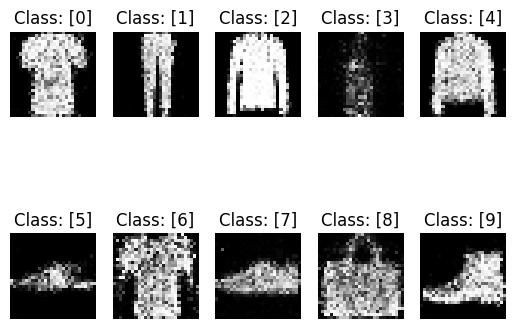

2/2 [==============================] - 0s 13ms/step
7000 [D loss: 0.681401252746582, acc.: 53.90625%] [G loss: 0.7102498412132263]
1/1 [==============================] - 0s 30ms/step


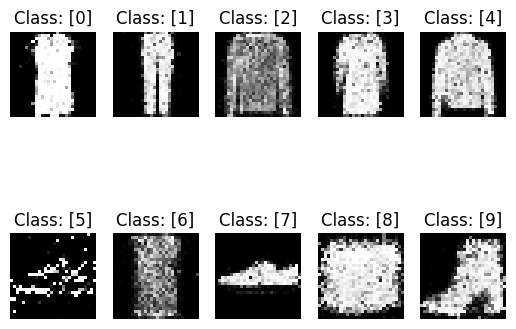

2/2 [==============================] - 0s 12ms/step
8000 [D loss: 0.6872296929359436, acc.: 53.125%] [G loss: 0.7283226251602173]
1/1 [==============================] - 0s 23ms/step


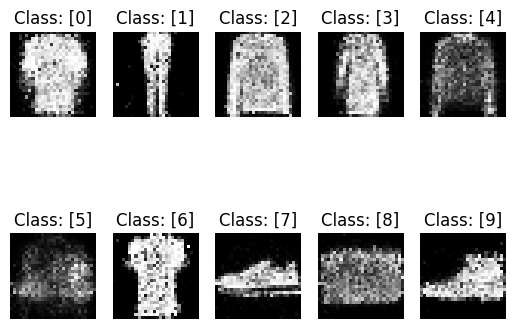

2/2 [==============================] - 0s 11ms/step
9000 [D loss: 0.7020383477210999, acc.: 50.0%] [G loss: 0.7252248525619507]
1/1 [==============================] - 0s 32ms/step


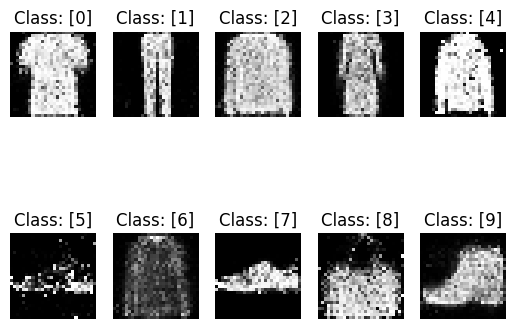

1/1 [==============================] - 0s 27ms/step


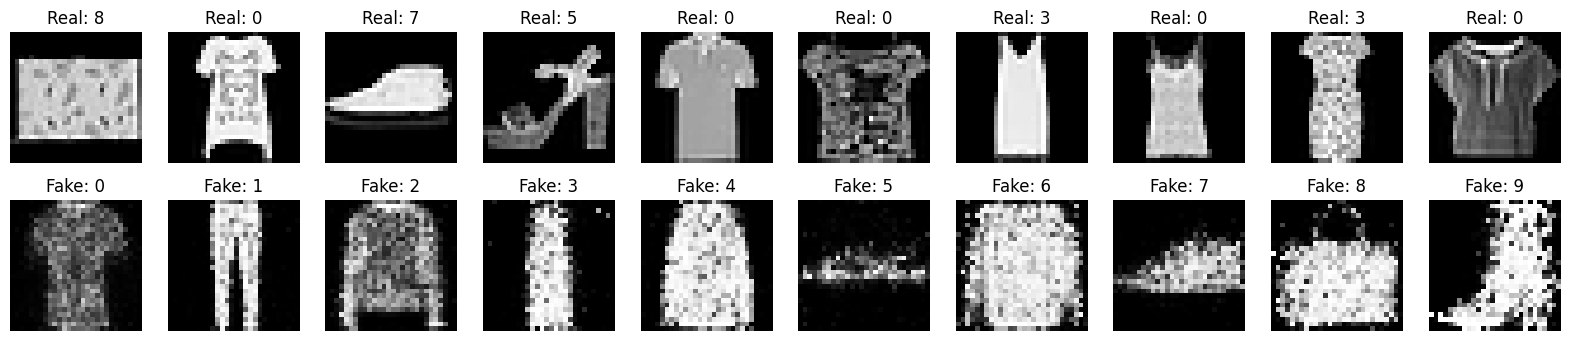

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding, multiply, Concatenate, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Combine train and test images and labels
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Normalize images to [-1, 1]
all_images = (all_images.astype(np.float32) - 127.5) / 127.5
all_images = np.expand_dims(all_images, axis=-1)

# Select a subset of 8,000 images and labels
subset_indices = np.random.choice(all_images.shape[0], 8000, replace=False)
subset_images = all_images[subset_indices]
subset_labels = all_labels[subset_indices]

# Parameters
img_shape = (28, 28, 1)
num_classes = 10
latent_dim = 100

# Build the Generator
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

# Build the Discriminator
def build_discriminator():
    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])
    validity = model(model_input)

    return Model([img, label], validity)

# Compile the models
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()

noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

discriminator.trainable = False

valid = discriminator([img, label])

combined = Model([noise, label], valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# Function to generate and display images
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Class: {sampled_labels[cnt]}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Training the Conditional GAN
def train(epochs, batch_size=128, sample_interval=200):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, subset_images.shape[0], batch_size)
        imgs, labels = subset_images[idx], subset_labels[idx]

         noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        gen_imgs = generator.predict([noise, gen_labels])

        d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        g_loss = combined.train_on_batch([noise, sampled_labels], valid)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")
            sample_images(epoch)

# Train the cGAN for 10000 epochs
train(epochs=10000, batch_size=64, sample_interval=1000)

# Real vs Fake analysis
def real_vs_fake():
    noise = np.random.normal(0, 1, (10, latent_dim))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = generator.predict([noise, sampled_labels])
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axs[0, i].imshow(subset_images[i, :, :, 0], cmap='gray')
        axs[0, i].set_title(f"Real: {subset_labels[i]}")
        axs[0, i].axis('off')
        axs[1, i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
        axs[1, i].set_title(f"Fake: {i}")
        axs[1, i].axis('off')
    plt.show()

real_vs_fake()